In [1]:
import tensorflow as tf

import cv2
import functools
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import xml.etree.ElementTree as ET
import yaml

from object_detection.utils import dataset_util
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFilter
from scipy.stats import norm
from shapely.geometry import Polygon
from shapely import affinity


%matplotlib inline
plt.style.use('ggplot')

## Create synthetic training data

In [11]:
sim_backgrounds = [
    'synthetic-data/backgrounds/sim/bg-1.jpg',
    'synthetic-data/backgrounds/sim/bg-2.jpg',
    'synthetic-data/backgrounds/sim/bg-3.jpg',
    'synthetic-data/backgrounds/sim/bg-4.jpg',
    'synthetic-data/backgrounds/sim/bg-5.jpg',
    'synthetic-data/backgrounds/sim/bg-6.jpg',
    'synthetic-data/backgrounds/sim/bg-7.jpg',
    'synthetic-data/backgrounds/sim/bg-8.jpg',
    'synthetic-data/backgrounds/sim/bg-9.jpg',
    'synthetic-data/backgrounds/sim/bg-10.jpg',
    'synthetic-data/backgrounds/sim/bg-11.jpg',
    'synthetic-data/backgrounds/sim/bg-12.jpg',
    'synthetic-data/backgrounds/sim/bg-13.jpg',
    'synthetic-data/backgrounds/sim/bg-14.jpg',
    'synthetic-data/backgrounds/sim/bg-15.jpg',
    'synthetic-data/backgrounds/sim/bg-16.jpg',
    'synthetic-data/backgrounds/sim/bg-17.jpg',
    'synthetic-data/backgrounds/sim/bg-18.jpg',
    'synthetic-data/backgrounds/sim/bg-19.jpg',
    'synthetic-data/backgrounds/sim/bg-20.jpg',
    'synthetic-data/backgrounds/sim/bg-21.jpg',
    'synthetic-data/backgrounds/sim/bg-22.jpg',
    'synthetic-data/backgrounds/sim/bg-23.jpg',
    'synthetic-data/backgrounds/sim/bg-24.jpg',
    'synthetic-data/backgrounds/sim/bg-25.jpg',
    'synthetic-data/backgrounds/sim/bg-26.jpg',
    'synthetic-data/backgrounds/sim/bg-27.jpg',
    'synthetic-data/backgrounds/sim/bg-28.jpg',
    'synthetic-data/backgrounds/sim/bg-29.jpg',
    'synthetic-data/backgrounds/sim/bg-30.jpg'
]
sim_red = [
    'synthetic-data/elements/sim/red-large.jpg',
    'synthetic-data/elements/sim/red-medium.jpg',
    'synthetic-data/elements/sim/red-small.jpg'
]
sim_green = [
    'synthetic-data/elements/sim/green-large.jpg',
    'synthetic-data/elements/sim/green-medium.jpg',
    'synthetic-data/elements/sim/green-small.jpg'
]
sim_yellow = [
    'synthetic-data/elements/sim/yellow-large.jpg',
    'synthetic-data/elements/sim/yellow-medium.jpg',
    'synthetic-data/elements/sim/yellow-small.jpg'
]

site_backgrounds = [
    'synthetic-data/backgrounds/site/bg-1.jpg',
    'synthetic-data/backgrounds/site/bg-2.jpg',
    'synthetic-data/backgrounds/site/bg-3.jpg',
    'synthetic-data/backgrounds/site/bg-4.jpg',
    'synthetic-data/backgrounds/site/bg-5.jpg',
    'synthetic-data/backgrounds/site/bg-6.jpg',
    'synthetic-data/backgrounds/site/bg-7.jpg',
    'synthetic-data/backgrounds/site/bg-8.jpg',
    'synthetic-data/backgrounds/site/bg-9.jpg',
    'synthetic-data/backgrounds/site/bg-10.jpg',
    'synthetic-data/backgrounds/site/bg-11.jpg',
    'synthetic-data/backgrounds/site/bg-12.jpg'
]
site_red = [
    'synthetic-data/elements/site/red-1.jpg',
    'synthetic-data/elements/site/red-2.jpg',
    'synthetic-data/elements/site/red-3.jpg',
    'synthetic-data/elements/site/red-4.jpg',
    'synthetic-data/elements/site/red-5.jpg',
    'synthetic-data/elements/site/red-6.jpg',
    'synthetic-data/elements/site/red-7.jpg',
    'synthetic-data/elements/site/red-8.jpg',
    'synthetic-data/elements/site/red-9.jpg',
    'synthetic-data/elements/site/red-10.jpg',
    'synthetic-data/elements/site/red-11.jpg',
    'synthetic-data/elements/site/red-12.jpg',
    'synthetic-data/elements/site/red-13.jpg',
    'synthetic-data/elements/site/red-14.jpg',
]
site_green = [
    'synthetic-data/elements/site/green-1.jpg',
    'synthetic-data/elements/site/green-2.jpg',
    'synthetic-data/elements/site/green-3.jpg',
    'synthetic-data/elements/site/green-4.jpg',
    'synthetic-data/elements/site/green-5.jpg',
    'synthetic-data/elements/site/green-6.jpg',
    'synthetic-data/elements/site/green-7.jpg',
    'synthetic-data/elements/site/green-8.jpg',
    'synthetic-data/elements/site/green-9.jpg',
    'synthetic-data/elements/site/green-10.jpg',
    'synthetic-data/elements/site/green-11.jpg',
    'synthetic-data/elements/site/green-12.jpg',
]
site_yellow = [
    'synthetic-data/elements/site/yellow-1.jpg',
    'synthetic-data/elements/site/yellow-2.jpg',
    'synthetic-data/elements/site/yellow-3.jpg',
    'synthetic-data/elements/site/yellow-4.jpg',
    'synthetic-data/elements/site/yellow-5.jpg',
    'synthetic-data/elements/site/yellow-6.jpg',
    'synthetic-data/elements/site/yellow-7.jpg',
    'synthetic-data/elements/site/yellow-8.jpg',
    'synthetic-data/elements/site/yellow-9.jpg',
    'synthetic-data/elements/site/yellow-10.jpg',
    'synthetic-data/elements/site/yellow-11.jpg',
]

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([
      ((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

def adjust_gamma(img, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([
      ((i / 255.0) ** inv_gamma) * 255
      for i in np.arange(0, 256)])
    return cv2.LUT(img.astype(np.uint8), table.astype(np.uint8))

def adjust_contrast(img):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(2,2))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img[:,:,0] = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

def preprocess(img, gamma):
    img = adjust_contrast(img)
    img = adjust_gamma(img, gamma)
    return img

def create_object(wrapper, label, bounding_box):
    obj = ET.SubElement(wrapper, 'object')

    name = ET.SubElement(obj, 'name')
    name.text = label
    
    pose = ET.SubElement(obj, 'pose')
    pose.text = 'Unspecified'
    
    truncated = ET.SubElement(obj, 'truncated')
    truncated.text = str(0)
    
    difficult = ET.SubElement(obj, 'difficult')
    difficult.text = str(0)

    bndbox = ET.SubElement(obj, 'bndbox')

    xmin = ET.SubElement(bndbox, 'xmin')
    xmin.text = str(bounding_box[0])

    ymin = ET.SubElement(bndbox, 'ymin')
    ymin.text = str(bounding_box[1])

    xmax = ET.SubElement(bndbox, 'xmax')
    xmax.text = str(bounding_box[2])

    ymax = ET.SubElement(bndbox, 'ymax')
    ymax.text = str(bounding_box[3])

def create_xml(name, width, height, bounding_boxes, labels):
    annotation = ET.Element('annotation')
    
    filename = ET.SubElement(annotation, 'filename')
    filename.text = name
    
    size = ET.SubElement(annotation, 'size')

    w = ET.SubElement(size, 'width')
    w.text = str(width)

    h = ET.SubElement(size, 'height')
    h.text = str(height)

    depth = ET.SubElement(size, 'depth')
    depth.text = str(3)
    
    segmented = ET.SubElement(annotation, 'segmented')
    segmented.text = str(0)
    
    for i in range(len(bounding_boxes)):
        create_object(annotation, labels[i], bounding_boxes[i])
    return annotation
    
def find_overlapping_bounding_box(bounding_boxes, new_bounding_box):
    max_intersection = 0
    for i in range(len(bounding_boxes)):
        min_x, min_y, max_x, max_y = bounding_boxes[i]
        new_min_x, new_min_y, new_max_x, new_max_y = new_bounding_box
#         print(new_bounding_box)
        existing_bb = Polygon([
            (min_x, min_y),
            (max_x, min_y),
            (max_x, max_y),
            (min_x, max_y)
        ])
        new_bb= Polygon([
            (new_min_x, new_min_y),
            (new_max_x, new_min_y),
            (new_max_x, new_max_y),
            (new_min_x, new_max_y)
        ])
        intersection = existing_bb.intersection(new_bb)
        area_of_overlap = intersection.area / new_bb.area if new_bb.area < existing_bb.area else intersection.area / existing_bb.area

        if area_of_overlap > max_intersection:
            max_intersection = area_of_overlap
    return max_intersection
        
def rotate_bb(bb, degrees):
    min_x, min_y, max_x, max_y = bb
    poly = Polygon([
        (min_x, min_y),
        (max_x, min_y),
        (max_x, max_y),
        (min_x, max_y)
    ])
    modified = affinity.rotate(poly, degrees)
    min_x, min_y, max_x, max_y = modified.bounds
    return [int(min_x), int(max_y), int(max_x), int(min_y)]
    
def rescale_bb(bb, ratio):
    min_x, min_y, max_x, max_y = bb
    poly = Polygon([
        (min_x, min_y),
        (max_x, min_y),
        (max_x, max_y),
        (min_x, max_y)
    ])
    modified = affinity.scale(poly, xfact=ratio, yfact=ratio)
    
    min_x, min_y, max_x, max_y = modified.bounds
    return [int(min_x), int(max_y), int(max_x), int(min_y)]

def add_to_image(bg, img_set, num, other_bounding_boxes):
    bounding_boxes = []
    for num_light in range(random.randint(1, num)):
        # 0 = large, 1 = medium, 2 = small
        img_num = random.randint(0, len(img_set) - 1)
        synth_image = Image.open(img_set[img_num]).convert('RGBA')
        
        # 50 percent chance of flipping the image horizontally
        flip_chance = random.uniform(0.0, 1.0)
        if flip_chance > 0.5:
            synth_image.transpose(Image.FLIP_LEFT_RIGHT)
            
        # get the element dimensions
        light_width, light_height = synth_image.size
        bg_width, bg_height = bg.size

        # random rotation/rescale rtios
        degrees = random.uniform(-3.0, 3.0)
        ratio = random.uniform(0.9, 1.8)
#         if img_num == 0:
#             # large images
#             ratio = random.uniform(0.5, 1.5)
#         elif img_num == 1:
#             # medium images
#             ratio = random.uniform(0.5, 1.5)
#         else:
#             # small images
#             ratio = random.uniform(0.7, 1.0)

        while True:
            upper_left_x = random.randint(-light_width / 2, bg_width - light_width / 2)
            upper_left_y = random.randint(-light_width / 2, bg_height + light_height / 2 - float(bg_height) * 0.4)

            bounding_box = rescale_bb(rotate_bb([
                upper_left_x,
                upper_left_y + light_height,
                upper_left_x + light_width,
                upper_left_y
            ], degrees), ratio)

            overlap = find_overlapping_bounding_box(bounding_boxes + other_bounding_boxes, bounding_box)
            # check to make sure this isn't osverlapping an existing image, and isn't over 50% off screen
            if overlap < 0.15 and bounding_box[3] < bg.size[1] - light_height / 2 and bounding_box[2] < bg.size[0] - light_width / 2:
                break
        
        # apply random rotation
        rotated_image = synth_image.rotate(degrees, expand=1)
        # apply random resizing
        rescaled_image = rotated_image.resize(
            (int(rotated_image.width * ratio), int(rotated_image.height * ratio)),
            resample=Image.BICUBIC
        )
        final_image = rescaled_image
        final_light_width, final_light_height = final_image.size
        # apply random gaussian blur to larger images
#         print('final_light_height', final_light_height)
        if final_light_height > 150:
            final_image = rescaled_image.filter(ImageFilter.GaussianBlur(radius=random.randint(0,1))) 
        bg.paste(
            final_image,
            (bounding_box[0], bounding_box[3]),
            final_image
        )

        # bounding box is in the format xmin, ymin, xmax, ymax
        bounding_boxes.append(bounding_box)
    return bounding_boxes

# at most we want the light half-obscured
# currently this outputs images and labels to a directory called output/ (model-playground/output/)
all_images = []
all_labels = []
entries = []
dest_folder = './evaluation-dataset/site/'
yaml_path = './evaluation-dataset/site/images.yaml'
backgrounds = site_backgrounds
green = site_green
yellow = site_yellow
red = site_red

num_backgrounds = len(backgrounds)

for i in range(2000):
    bg = Image.open(backgrounds[random.randint(0, num_backgrounds - 1)])

    filename = 'synthetic-' + str(i)
    bounding_boxes = []
    labels = []

    new_bounding_boxes = add_to_image(bg, green, 3, bounding_boxes)
    for i in range(len(new_bounding_boxes)):
        labels.append('Green_light')
        bounding_boxes.append(new_bounding_boxes[i])

    new_bounding_boxes = add_to_image(bg, yellow, 3, bounding_boxes)
    for i in range(len(new_bounding_boxes)):
        labels.append('Yellow_light')
        bounding_boxes.append(new_bounding_boxes[i])

    new_bounding_boxes = add_to_image(bg, red, 3, bounding_boxes)
    for i in range(len(new_bounding_boxes)):
        labels.append('Red_light')
        bounding_boxes.append(new_bounding_boxes[i])

    bg_width, bg_height = bg.size
    
    annotation = create_xml(filename + '.jpg', bg_width, bg_height, bounding_boxes, labels)
    ET.ElementTree(annotation).write(dest_folder + filename + '.xml')
    image_filename = dest_folder + filename + '.jpg'
    
    bg = Image.fromarray(preprocess(np.asarray(bg), random.uniform(0.4, 0.6)))
    bg.save(image_filename)
    
    # everything below is for writing yaml file for the tfrecord conversion
    all_labels.append([bounding_boxes, labels])
    entry = {
        'path': '',
        'boxes': []
    }
    entry['path'] = image_filename
    for i in range(len(bounding_boxes)):
        x_min, y_min, x_max, y_max = bounding_boxes[i]
        entry['boxes'].append({
            'label': labels[i],
            'x_min': x_min,
            'x_max': x_max,
            # reverse y min and max because the Y axis flips
            'y_min': y_max,
            'y_max': y_min,
        })
    
    entries.append(entry)

with open(yaml_path, 'w') as file:
    yaml.dump(entries, file)

print('Done!')
#     plt.imshow(bg)

IOError: [Errno 2] No such file or directory: './evaluation-dataset/site/synthetic-0.xml'

# Analysis of content of existing database

In [34]:
directoryGreen = "./alex-data/simulator_dataset_rgb/Green/labels/"
directoryYellow = "./alex-data/simulator_dataset_rgb/Yellow/labels/"
directoryRed = "./alex-data/simulator_dataset_rgb/Red/labels/"

directory = directoryRed

with open("evaluation_simulator_training_dataset.csv", "a") as myfile:
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            root = ET.parse(directory+filename).getroot()
            for obj in root.findall('object'):
                myfile.write(obj.find('name').text + ",")
                bbox = obj.find('bndbox')
                myfile.write(bbox.find('xmin').text + ",")
                myfile.write(bbox.find('xmax').text + ",")
                myfile.write(bbox.find('ymin').text + ",")
                myfile.write(bbox.find('ymax').text)
                myfile.write("\n")

### Create TFRecord

In [98]:
INPUT_YAML = "./evaluation-dataset/site/images.yaml"
TFRECORD_DESTINATION = './evaluation-dataset/site/images.record'

LABEL_DICT =  {
    "Green_light" : 1,
    "Red_light" : 2,
    "Yellow_light" : 3,
}

def create_tf_record(example):

    height = 600 # Image height
    width = 800 # Image width

    filename = example['path'] # Filename of the image. Empty if image is not from file
    filename = filename.encode()

    with tf.gfile.GFile(example['path'], 'rb') as fid:
        encoded_image = fid.read()

    image_format = 'jpg'.encode()

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
                # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
                # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)

    for box in example['boxes']:
        #if box['occluded'] is False:
        #print("adding box")
        xmins.append(float(float(box['x_min']) / float(width)))
        xmaxs.append(float(float(box['x_max']) / float(width)))
        ymins.append(float(float(box['y_min']) / float(height)))
        ymaxs.append(float(float(box['y_max']) / float(height)))
        classes_text.append(box['label'].encode())
        classes.append(int(LABEL_DICT[box['label']]))


    tf_record = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    return tf_record

print(tf)
writer = tf.python_io.TFRecordWriter(TFRECORD_DESTINATION)

print("Reading yaml...")
examples = yaml.load(open(INPUT_YAML, 'rb').read())

len_examples = len(examples)
print("Loaded " + str(len(examples)) + " examples...")

for i in range(2000):
    examples[i]['path'] = os.path.abspath(examples[i]['path'])
    example = examples[i]
    
#     print(example)
    tf_record = create_tf_record(example)
    writer.write(tf_record.SerializeToString())

writer.close()

print("Done!")

<module 'tensorflow' from '/Users/gleb/miniconda3/envs/carnd-capstone/lib/python2.7/site-packages/tensorflow/__init__.pyc'>
Reading yaml...


/Users/gleb/miniconda3/envs/carnd-capstone/lib/python2.7/site-packages/ipykernel_launcher.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loaded 5000 examples...
Done!


### Test detection code

In [2]:


# the following function is to add data in a dictionary in order to analyse the detection boxes based on the bbox size
INDEX_DETECT_CORRECTLY = 0
INDEX_DETECT_INCORRECTLY = 1
INDEX_NOT_DETECTED = 2
INDEX_TOTAL_SAMPLE = 3

def add_bbox_sample(dictionary, bbox_size, light_color_id, is_detected, is_detected_correctly):
    if not ((bbox_size,light_color_id) in dictionary):
        dictionary.update({(bbox_size,light_color_id):[0,0,0,0]})
    #update
    if is_detected:
        if is_detected_correctly:
            dictionary[(bbox_size,light_color_id)][INDEX_DETECT_CORRECTLY] += 1
        else:
            dictionary[(bbox_size,light_color_id)][INDEX_DETECT_INCORRECTLY] += 1
    else:
        dictionary[(bbox_size,light_color_id)][INDEX_NOT_DETECTED] += 1
    dictionary[(bbox_size,light_color_id)][INDEX_TOTAL_SAMPLE] += 1

In [5]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [4]:

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, colors, thickness=3):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = colors[class_id - 1]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)


detection_graph = load_graph('./model/site/ssd_mobilenet_v1_coco_10000_synthetic/frozen_inference_graph.pb')


# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')


image = Image.open('./evaluation-dataset/site/synthetic-4.jpg')
image = Image.open('./assets/site-green-102.jpg')
image = np.asarray(image)

image = preprocess(image)
# image = np.asarray(image)
# image = adjust_gamma(image, 0.5)
# image = Image.fromarray(image)

image = Image.fromarray(image)
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.5
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    print(scores)
    print(classes)
    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes, ['green', 'yellow', 'red', 'gray'])
#     print(detection_classes)
#     print(classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

NotFoundError: ./model/site/ssd_mobilenet_v1_coco_10000_synthetic/frozen_inference_graph.pb; No such file or directory

In [32]:
#to store in the file where we record data for evaluation
MODEL_NAME = "ssd_mobilenet_v1_coco_40000_external_site"
NUM_STEPS = 40000
DATABASE_TRAIN_NAME = "test_train"
DATABASE_EVAL_NAME = "SyntheticDataOriginalGamma"
SYNTHETIC_DATA = "No"

evaluation_folder = './SyntheticDataOriginalGamma/'
detection_graph = load_graph('./graphsModels/ssd_mobilenet_v1_coco_40000_external_site.pb')

def distance(x1, y1, x2, y2):
    return math.sqrt(pow(x2 - x1, 2) + pow(y2 - y1, 2))

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

label_mapping = {
    'Green_light': 1,
    'Red_light': 2,
    'Yellow_light': 3
}
# image = preprocess(image)

with tf.Session(graph=detection_graph) as sess:
    # correct is when an expected bounding box is detected and is labelled correctly
    correct = {
        '1': 0,
        '2': 0,
        '3': 0,
    }
    # incorrect is when an expected bounding box is detected and is labelled incorrectly
    incorrect = {
        '1': 0,
        '2': 0,
        '3': 0,
    }
    # non-detected is when an expected bounding box is not detected
    not_detected = {
        '1': 0,
        '2': 0,
        '3': 0,
    }
    # background_as_trafficLight is when we have detected a bounding box but there is not any traffic light (i.e. when the bounding box detected falls into background)
    background_as_trafficLight = {
        '1': 0,
        '2': 0,
        '3': 0,
    }
    total = {
        '1': 0,
        '2': 0,
        '3': 0,
    }
    
    bbox_analysis = {}

    for idx_image in range(500):
        sample_name = 'synthetic-' + str(idx_image)
        image = Image.open(evaluation_folder + sample_name + '.jpg')
        image = np.asarray(image)
        image = preprocess(image, 0.6)
        image = Image.fromarray(image)
        image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.4
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
#         print(boxes)
#         print(scores)
        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)
        
        label_xml = ET.parse(evaluation_folder + sample_name + '.xml')
        expected_bbs = []
        expected_classes = []
        correpondent_detected = [False] * len(boxes)
        for label in label_xml.findall('object'):
            expected = label_mapping[label.find('name').text]
            expected_classes.append(expected)
#             print(expected)
            box = label.find('bndbox')
            min_x = int(box.find('xmin').text)
            min_y = int(box.find('ymin').text)
            max_x = int(box.find('xmax').text)
            max_y = int(box.find('ymax').text)
            
            bbox_size = abs(max_y-min_y)*abs(max_x-min_x)
            
            expected_bbs.append([min_y, min_x, max_y, max_x])
#             expected_bb = Polygon([
#                 (min_y, min_x),
#                 (max_x, min_y),
#                 (max_x, max_y),
#                 (min_x, max_y)
#             ])
            total[str(expected)] += 1
#             print('\ntesting')
#             print([max_y, min_x, min_y, max_x])
#             print('expected class: ' + str(expected))
#             print('\n')

            detected = False
            for i in range(len(box_coords)):
                new_min_y, new_min_x, new_max_y, new_max_x = box_coords[i]
#                 actual_bb = Polygon([
#                     (new_min_x, new_min_y),
#                     (new_max_x, new_min_y),
#                     (new_max_x, new_max_y),
#                     (new_min_x, new_max_y)
#                 ])
#                 intersection = expected_bb.intersection(actual_bb)
#                 area_of_overlap = intersection.area / actual_bb.area if actual_bb.area < expected_bb.area else intersection.area / expected_bb.area
#                 print(box_coords[i])
#                 print('overlap: ' + str(area_of_overlap))
                # consider it a match if there is 75% overlap
                # distance of top left corners
                dist_tl = distance(min_x, max_y, new_min_x, new_min_y)
#                 print(dist_tl)
                # distance of bottom right corners
                dist_br = distance(max_x, min_y, new_max_x, new_max_y)
#                 print(dist_br)
#                 print('predicted class: ' + str(int(classes[i])))
                avg_corner_distance = (dist_tl + dist_br) / 2
#                 print('avg corner distance: ' + str(avg_corner_distance))
                if avg_corner_distance < 40:# and area_of_overlap > 0.7:
                    correpondent_detected[i] = True
                    detected = True
                    if int(classes[i]) == expected:
                        correct[str(expected)] += 1
                        add_bbox_sample(bbox_analysis, bbox_size, str(expected), True, True)
                    else:
                        incorrect[str(expected)] += 1
                        add_bbox_sample(bbox_analysis, bbox_size, str(expected), True, False)
            if not detected:
                not_detected[str(expected)] += 1
                add_bbox_sample(bbox_analysis, bbox_size, str(expected), False, False)
        
        for i in range(len(box_coords)):
            if correpondent_detected[i] is False:
                background_as_trafficLight[str(int(classes[i]))] += 1
            
            #d = dict(zip(unique, counts))
            #non_correspondance[int(classes[i])] += d[False]

#         print(expected_bbs)

#         print(np.array(expected_bbs))
#         print(box_coords)
#         draw_boxes(image, np.array(expected_bbs), expected_classes, ['#c2f6a8', '#f68d8d', '#f6eaa8', 'gray'])
#         draw_boxes(image, box_coords, classes, ['green', 'red', 'yellow', 'gray'])
    #     print(detection_classes)
    #     print(classes)

#         plt.figure(figsize=(12, 8))
#         plt.imshow(image) 
    print('Note: it is possible that total expected lights is different from the detected correct plus detected incorrect\nsince it is possible that we have two overlapping bounding boxes')
    print('Green:')
    print('Total expected lights: ' + str(total['1']))
    print('Detected Correct: ' + str(correct['1']))
    print('Detected Incorrect: ' + str(incorrect['1']))
    print('Not detected: ' + str(not_detected['1']))
    print('Background as traffic light: ' + str(background_as_trafficLight['1']))
    print('Accuracy: '+  str(correct['1'] / float(total['1'])))
    print('\nRed:')
    print('Total expected lights: ' + str(total['2']))
    print('Detected Correct: ' + str(correct['2']))
    print('Detected Incorrect: ' + str(incorrect['2']))
    print('Not detected: ' + str(not_detected['2']))
    print('Background as traffic light: ' + str(background_as_trafficLight['2']))
    print('Accuracy: '+  str(correct['2'] / float(total['2'])))
    print('\nYellow:')
    print('Total expected lights: ' + str(total['3']))
    print('Detected Correct: ' + str(correct['3']))
    print('Detected Incorrect: ' + str(incorrect['3']))
    print('Not detected: ' + str(not_detected['3']))
    print('Background as traffic light: ' + str(background_as_trafficLight['3']))
    print('Accuracy: '+  str(correct['3'] / float(total['3'])))
    

    with open("evaluation_model_accuracy_site_11nov.csv", "a") as myfile:
        for i in range(3): # for all the colors
            myfile.write(MODEL_NAME + ",")
            myfile.write(str(NUM_STEPS) + ",")
            myfile.write(DATABASE_TRAIN_NAME + ",")
            myfile.write(DATABASE_EVAL_NAME + ",")
            myfile.write(SYNTHETIC_DATA + ",")
            myfile.write(str(i+1) + ",") #colour
            myfile.write(str(total[str(i+1)]) + ", ")
            myfile.write(str(correct[str(i+1)]) + ", ")
            myfile.write(str(incorrect[str(i+1)]) + ", ")
            myfile.write(str(not_detected[str(i+1)]) + ", ")
            myfile.write(str(background_as_trafficLight[str(i+1)]))
            myfile.write("\n")


    with open("evaluation_model_accuracy_bbox_site_11nov.csv", "a") as myfile:
        for x in bbox_analysis.keys():
            myfile.write(MODEL_NAME + ",")
            myfile.write(str(NUM_STEPS) + ",")
            myfile.write(DATABASE_TRAIN_NAME + ",")
            myfile.write(DATABASE_EVAL_NAME + ",")
            myfile.write(str(x[1]) + ",") # traffic light color
            myfile.write(str(x[0]) + ",") # bbox size
            myfile.write(str(bbox_analysis[x][INDEX_DETECT_CORRECTLY]) + ",") # detection correct
            myfile.write(str(bbox_analysis[x][INDEX_DETECT_INCORRECTLY]) + ",") # detection incorrect
            myfile.write(str(bbox_analysis[x][INDEX_NOT_DETECTED]) + ",") # not detected
            myfile.write(str(bbox_analysis[x][INDEX_TOTAL_SAMPLE])) # total samples
            myfile.write("\n")
        
    
    
    

    


Note: it is possible that total expected lights is different from the detected correct plus detected incorrect
since it is possible that we have two overlapping bounding boxes
Green:
Total expected lights: 968
Detected Correct: 294
Detected Incorrect: 2
Not detected: 673
Background as traffic light: 10
Accuracy: 0.303719008264

Red:
Total expected lights: 1017
Detected Correct: 56
Detected Incorrect: 381
Not detected: 590
Background as traffic light: 2
Accuracy: 0.055063913471

Yellow:
Total expected lights: 969
Detected Correct: 6
Detected Incorrect: 286
Not detected: 683
Background as traffic light: 0
Accuracy: 0.0061919504644


# Analysis with different gamma steps

In [31]:
#to store in the file where we record data for evaluation
MODEL_NAME = "ssd_mobilenet_v1_coco_10000_gamma"
NUM_STEPS = 10000
DATABASE_TRAIN_NAME = "test_train"
DATABASE_EVAL_NAME = "SyntheticDataOriginalGamma"
SYNTHETIC_DATA = "No"

evaluation_folder = './SyntheticDataOriginalGamma/'
detection_graph = load_graph('./graphsModels/ssd_mobilenet_v1_coco_10000_gamma.pb')

def distance(x1, y1, x2, y2):
    return math.sqrt(pow(x2 - x1, 2) + pow(y2 - y1, 2))

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

label_mapping = {
    'Green_light': 1,
    'Red_light': 2,
    'Yellow_light': 3
}
# image = preprocess(image)

with tf.Session(graph=detection_graph) as sess:
    for i in xrange(40,100,5):
        # correct is when an expected bounding box is detected and is labelled correctly
        correct = {
            '1': 0,
            '2': 0,
            '3': 0,
        }
        # incorrect is when an expected bounding box is detected and is labelled incorrectly
        incorrect = {
            '1': 0,
            '2': 0,
            '3': 0,
        }
        # non-detected is when an expected bounding box is not detected
        not_detected = {
            '1': 0,
            '2': 0,
            '3': 0,
        }
        # background_as_trafficLight is when we have detected a bounding box but there is not any traffic light (i.e. when the bounding box detected falls into background)
        background_as_trafficLight = {
            '1': 0,
            '2': 0,
            '3': 0,
        }
        total = {
            '1': 0,
            '2': 0,
            '3': 0,
        }

        bbox_analysis = {}
        gammaValue = i/100.
    
        for idx_image in range(500):
            sample_name = 'synthetic-' + str(idx_image)
            image = Image.open(evaluation_folder + sample_name + '.jpg')
            image = np.asarray(image)
            image = preprocess(image, gammaValue)
            image = Image.fromarray(image)
            image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
            (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                                feed_dict={image_tensor: image_np})

            # Remove unnecessary dimensions
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes)

            confidence_cutoff = 0.4
            # Filter boxes with a confidence score less than `confidence_cutoff`
            boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    #         print(boxes)
    #         print(scores)
            # The current box coordinates are normalized to a range between 0 and 1.
            # This converts the coordinates actual location on the image.
            width, height = image.size
            box_coords = to_image_coords(boxes, height, width)

            label_xml = ET.parse(evaluation_folder + sample_name + '.xml')
            expected_bbs = []
            expected_classes = []
            correpondent_detected = [False] * len(boxes)
            for label in label_xml.findall('object'):
                expected = label_mapping[label.find('name').text]
                expected_classes.append(expected)
    #             print(expected)
                box = label.find('bndbox')
                min_x = int(box.find('xmin').text)
                min_y = int(box.find('ymin').text)
                max_x = int(box.find('xmax').text)
                max_y = int(box.find('ymax').text)

                bbox_size = abs(max_y-min_y)*abs(max_x-min_x)

                expected_bbs.append([min_y, min_x, max_y, max_x])
    #             expected_bb = Polygon([
    #                 (min_y, min_x),
    #                 (max_x, min_y),
    #                 (max_x, max_y),
    #                 (min_x, max_y)
    #             ])
                total[str(expected)] += 1
    #             print('\ntesting')
    #             print([max_y, min_x, min_y, max_x])
    #             print('expected class: ' + str(expected))
    #             print('\n')

                detected = False
                for i in range(len(box_coords)):
                    new_min_y, new_min_x, new_max_y, new_max_x = box_coords[i]
    #                 actual_bb = Polygon([
    #                     (new_min_x, new_min_y),
    #                     (new_max_x, new_min_y),
    #                     (new_max_x, new_max_y),
    #                     (new_min_x, new_max_y)
    #                 ])
    #                 intersection = expected_bb.intersection(actual_bb)
    #                 area_of_overlap = intersection.area / actual_bb.area if actual_bb.area < expected_bb.area else intersection.area / expected_bb.area
    #                 print(box_coords[i])
    #                 print('overlap: ' + str(area_of_overlap))
                    # consider it a match if there is 75% overlap
                    # distance of top left corners
                    dist_tl = distance(min_x, max_y, new_min_x, new_min_y)
    #                 print(dist_tl)
                    # distance of bottom right corners
                    dist_br = distance(max_x, min_y, new_max_x, new_max_y)
    #                 print(dist_br)
    #                 print('predicted class: ' + str(int(classes[i])))
                    avg_corner_distance = (dist_tl + dist_br) / 2
    #                 print('avg corner distance: ' + str(avg_corner_distance))
                    if avg_corner_distance < 40:# and area_of_overlap > 0.7:
                        correpondent_detected[i] = True
                        detected = True
                        if int(classes[i]) == expected:
                            correct[str(expected)] += 1
                            add_bbox_sample(bbox_analysis, bbox_size, str(expected), True, True)
                        else:
                            incorrect[str(expected)] += 1
                            add_bbox_sample(bbox_analysis, bbox_size, str(expected), True, False)
                if not detected:
                    not_detected[str(expected)] += 1
                    add_bbox_sample(bbox_analysis, bbox_size, str(expected), False, False)

            for i in range(len(box_coords)):
                if correpondent_detected[i] is False:
                    background_as_trafficLight[str(int(classes[i]))] += 1

                #d = dict(zip(unique, counts))
                #non_correspondance[int(classes[i])] += d[False]

    #         print(expected_bbs)

    #         print(np.array(expected_bbs))
    #         print(box_coords)
    #         draw_boxes(image, np.array(expected_bbs), expected_classes, ['#c2f6a8', '#f68d8d', '#f6eaa8', 'gray'])
    #         draw_boxes(image, box_coords, classes, ['green', 'red', 'yellow', 'gray'])
        #     print(detection_classes)
        #     print(classes)

    #         plt.figure(figsize=(12, 8))
    #         plt.imshow(image) 
   
    

        with open("evaluation_model_accuracy_gamma_11nov.csv", "a") as myfile:
            for i in range(3): # for all the colors
                myfile.write(MODEL_NAME + ",")
                myfile.write(str(NUM_STEPS) + ",")
                myfile.write(DATABASE_TRAIN_NAME + ",")
                myfile.write(DATABASE_EVAL_NAME + ",")
                myfile.write(SYNTHETIC_DATA + ",")
                myfile.write(str(i+1) + ",") #colour
                myfile.write(str(total[str(i+1)]) + ", ")
                myfile.write(str(correct[str(i+1)]) + ", ")
                myfile.write(str(incorrect[str(i+1)]) + ", ")
                myfile.write(str(not_detected[str(i+1)]) + ", ")
                myfile.write(str(background_as_trafficLight[str(i+1)]) + ", ")
                myfile.write(str(gammaValue))
                myfile.write("\n")

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [212]:
def time_detection(sess, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    numImages = 100
    times = []
    for idx_image in range(numImages):
        sample_name = 'synthetic-' + str(idx_image)
        image = Image.open(evaluation_folder + sample_name + '.jpg')
        image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
        
        for i in range(runs):
            t0 = time.time()
            sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
            t1 = time.time()
            times.append((t1 - t0) * 1000)
    return times

In [ ]:
#to store in the file where we record data for evaluation
MODEL_NAME = "ssd_mobilenet_v1_coco_10000"        
evaluation_folder = './synthetic-dataset-oct-30-with-labels/'
detection_graph = load_graph('./graphsModels/ssd_mobilenet_v1_coco_10000.pb')

with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, runs=10)
    with open("evaluation_model_object_detection_timings.csv", "a") as myfile:
        myfile.write(MODEL_NAME + ",") 
        myfile.write(str(np.mean(times)) + ",") 
        myfile.write(str(np.std(times)))
        myfile.write("\n")

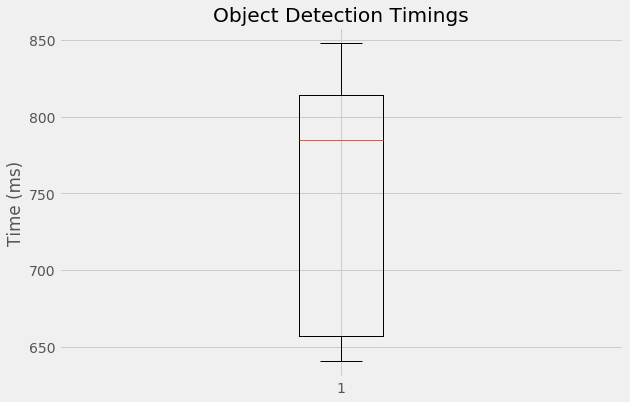

In [198]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

In [211]:
np.mean(times)
np.std(times)

161.2577597816605

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('driving.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [13]:
clip = VideoFileClip('driving.mp4')

In [29]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    draw_img = Image.fromarray(img)
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: np.expand_dims(img, 0)})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.3
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [30]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4', audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|██████████| 1782/1782 [07:31<00:00,  3.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [26]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
